# CESM2-LE Initial Condition Memory:  AMOC
 - Use Intake to access CESM2LE data on glade
 - Compute annual AMOC(1000m) from POP monthly output for all members from 1850-2100
 - Plot Hovmuller of micro-to-total variance vs. time
 - Request at least 50GB on Casper login to run this notebook

In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
from os.path import exists
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import calc
import intake
import pop_tools
from datetime import timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create Dask Cluster

In [28]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=2:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

In [4]:
cluster

In [2]:
pp_datafile = '/glade/scratch/yeager/cesm2_le/CESM2LE_MOC.nc'
if (exists(pp_datafile)):
        print(pp_datafile+' already exists.\n\n')
else:
    print(pp_datafile+' does NOT exist.\n\n')

/glade/scratch/yeager/cesm2_le/CESM2LE_MOC.nc already exists.




If CESM2LE post-processed zonal mean SST file already exists, you don't need to do Section 1 (~30 minutes). Go to [Section 2](#section2). 

# Section 1

## Data Intake

In [5]:
# Point to the catalog file
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
#catalog_file = '/glade/work/mgrover/intake-esm-catalogs/glade-cesm2-le.json'

# Open the catalog using intake
col = intake.open_esm_datastore(catalog_file)

/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [6]:
oceandata = col.search(component='ocn', variable=['MOC'])

In [9]:
oceandata.df

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,MOC,1850-01,1859-12,185001-185912,Meridional Overturning Circulation,Sverdrups,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
1,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,MOC,1860-01,1869-12,186001-186912,Meridional Overturning Circulation,Sverdrups,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
2,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,MOC,1870-01,1879-12,187001-187912,Meridional Overturning Circulation,Sverdrups,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
3,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,MOC,1880-01,1889-12,188001-188912,Meridional Overturning Circulation,Sverdrups,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
4,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,MOC,1890-01,1899-12,189001-189912,Meridional Overturning Circulation,Sverdrups,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,ocn,pop.h,b.e21.BSSP370smbb.f09_g17.LE2-1301.020,r20i1301p1f2,MOC,2055-01,2064-12,205501-206412,Meridional Overturning Circulation,Sverdrups,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,ssp370,smbb,1301.020,1301,CESM2_ssp370_r20i1301p1f2
2596,ocn,pop.h,b.e21.BSSP370smbb.f09_g17.LE2-1301.020,r20i1301p1f2,MOC,2065-01,2074-12,206501-207412,Meridional Overturning Circulation,Sverdrups,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,ssp370,smbb,1301.020,1301,CESM2_ssp370_r20i1301p1f2
2597,ocn,pop.h,b.e21.BSSP370smbb.f09_g17.LE2-1301.020,r20i1301p1f2,MOC,2075-01,2084-12,207501-208412,Meridional Overturning Circulation,Sverdrups,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,ssp370,smbb,1301.020,1301,CESM2_ssp370_r20i1301p1f2
2598,ocn,pop.h,b.e21.BSSP370smbb.f09_g17.LE2-1301.020,r20i1301p1f2,MOC,2085-01,2094-12,208501-209412,Meridional Overturning Circulation,Sverdrups,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,ssp370,smbb,1301.020,1301,CESM2_ssp370_r20i1301p1f2


In [6]:
# Find POP TEMP and SALT assets
oceandata = col.search(component='ocn', variable=['MOC'], experiment=['historical','ssp370'])

In [7]:
## Use preprocessor to return annual mean MOC
def preproc(ds):
    ds = calc.center_time(ds)
    ds_ann = ds.groupby('time.year').mean().rename({'year':'time'})
    ds_ann = ds_ann.sum('moc_comp')
    ds_ann.MOC.attrs = ds.MOC.attrs
    return ds_ann

In [8]:
%%time
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Create a dataset dictionary from the subsampled catalog
cbc_args = {'data_vars':'minimal'}
dsets = oceandata.to_dataset_dict(
    #xarray_combine_by_coords_kwargs=cbc_args,
    preprocess=preproc)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 59.5 s, sys: 2.33 s, total: 1min 1s
Wall time: 1min 45s


In [9]:
dsets.keys()

dict_keys(['ocn.historical.pop.h.cmip6.MOC', 'ocn.ssp370.pop.h.smbb.MOC', 'ocn.historical.pop.h.smbb.MOC', 'ocn.ssp370.pop.h.cmip6.MOC'])

In [10]:
dsets['ocn.ssp370.pop.h.smbb.MOC'].MOC

,Array,Chunk
Bytes,790.47 MiB,188.24 kiB
Shape,"(50, 86, 2, 61, 395)","(1, 1, 2, 61, 395)"
Count,52500 Tasks,4300 Chunks
Type,float32,numpy.ndarray


## Data Processing

No further processing required, just load data arrays:

In [11]:
%%time
cmip6hist = dsets['ocn.historical.pop.h.cmip6.MOC'].MOC.load()
smbbhist = dsets['ocn.historical.pop.h.smbb.MOC'].MOC.load()
cmip6ssp = dsets['ocn.ssp370.pop.h.cmip6.MOC'].MOC.load()
smbbssp = dsets['ocn.ssp370.pop.h.smbb.MOC'].MOC.load()

CPU times: user 1min 27s, sys: 7.75 s, total: 1min 34s
Wall time: 1min 41s


In [12]:
## Create final Dataset:
work1 = xr.concat([cmip6hist,cmip6ssp],dim='time')
work2 = xr.concat([smbbhist,smbbssp],dim='time')
cesm2le = xr.concat([work1,work2],dim='member_id')
memid = cesm2le.member_id.data
inityear = xr.DataArray([i.split('i')[1].split('p')[0] for i in memid],coords={'member_id':cesm2le.member_id})
memnum = xr.DataArray([i.split('i')[0].split('r')[1].rjust(3,'0') for i in memid],coords={'member_id':cesm2le.member_id})

ds = cesm2le.to_dataset()
ds['inityear'] = inityear
ds['memnum'] = memnum

In [13]:
pp_datafile

'/glade/scratch/yeager/cesm2_le/CESM2LE_MOC.nc'

In [14]:
## Save to netcdf:
ds.to_netcdf(pp_datafile)

<a id='section2'></a>

# Section 2

If you skipped Section 1, read in ds for analysis and plotting:

In [3]:
print('opening '+pp_datafile)
ds = xr.open_dataset(pp_datafile)

opening /glade/scratch/yeager/cesm2_le/CESM2LE_MOC.nc


In [4]:
ds

<xarray.Dataset>
Dimensions:       (lat_aux_grid: 395, moc_z: 61, time: 251, member_id: 100, transport_reg: 2)
Coordinates:
  * lat_aux_grid  (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z         (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
  * time          (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * member_id     (member_id) object 'r10i1181p1f1' ... 'r9i1171p1f2'
Dimensions without coordinates: transport_reg
Data variables:
    MOC           (member_id, time, transport_reg, moc_z, lat_aux_grid) float32 ...
    inityear      (member_id) object ...
    memnum        (member_id) object ...

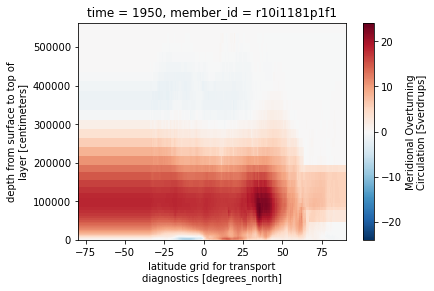

In [10]:
ds.MOC.isel(time=100,member_id=0,transport_reg=1).plot()

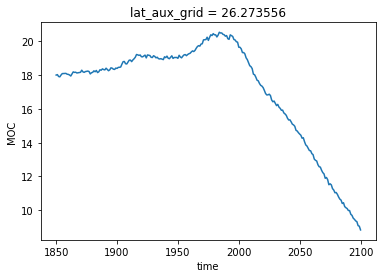

In [12]:
ds.MOC.sel(moc_z=slice(50000.,None)).isel(transport_reg=1).max('moc_z').sel(lat_aux_grid=26.5,method='nearest').mean('member_id').plot()

In [7]:
# Just grab AMOC at 1000m:
ds = ds.sel(moc_z=100000.,method='nearest')

First, apply low-pass filter

In [8]:
def lpf_anndata(dat, period=10):
    fs=1/(365*24*3600)        # 1 year in Hz (sampling frequency)
    nyquist = fs / 2          # 0.5 times the sampling frequency
    cutoff = fs/period            # cutoff frequency
    cutoff = cutoff/nyquist   # as fraction of nyquist  
    print('cutoff= ',(1/(cutoff*nyquist))/(365*24*3600),' years') 
    filtsos = signal.butter(4, cutoff, 'lowpass', output='sos') #low pass filter
    filtb, filta = signal.butter(4, cutoff, 'lowpass')
    dat_out = xr.apply_ufunc(signal.sosfiltfilt, filtsos,dat.fillna(0),kwargs={'padtype':'even','axis':0}).where(dat.notnull())
    return dat_out

In [9]:
ds['MOC'] = lpf_anndata(ds.MOC.transpose('time','transport_reg','member_id','lat_aux_grid'),period=15)

cutoff=  15.000000000000002  years


In [10]:
# Print summary of initialization years in dataset
iyear = ds.inityear.data
print("Start Year : Members")
for i in set(iyear):
    count = np.count_nonzero(iyear==i)
    print(i+" : "+str(count).zfill(3))

Start Year : Members
1181 : 001
1151 : 001
1251 : 020
1051 : 001
1031 : 001
1231 : 020
1021 : 001
1141 : 001
1081 : 001
1071 : 001
1301 : 020
1001 : 001
1091 : 001
1101 : 001
1161 : 001
1131 : 001
1041 : 001
1281 : 020
1171 : 001
1061 : 001
1011 : 001
1111 : 001
1191 : 001
1121 : 001


## Guide to Micro and Macro Ensembles:
  - 20-member micro ensembles referred to by start year: 1231, 1251, 1281, 1301
  - 10-member "macro1a" ensemble, initialized: 1001, 1021, 1041, 1061, 1081, 1101, 1121, 1141, 1161, 1181
  - 10-member "macro1b" (MOAR) ensemble, initialized: 1011, 1031, 1051, 1071, 1091, 1111, 1131, 1151, 1171, 1191
  - 10-member "macro2" ensemble (CMIP6 contribution):  b.e21.BHIST.f09_g17.CMIP6-historical.{001-010}


## Decomposition of Ensemble Variance:

Following Singh et al. (2021, in review), decompose CESM2LE ensemble variance for variable X as follows: 
$$ 
\sigma^{2}_{X} = \sigma^{2}_{X,ocn} + \sigma^{2}_{X,atm} 
$$ 
where "ocn" quantifies spread between micro ensembles (due to different ocean initial conditions), and "atm" quantifies spread within micro ensembles (due to perturbed atmospheric initial conditions). Variance within micro ensembles is computed as the average ensemble variance (with p=4, m=20):
$$ 
\sigma^{2}_{X,atm} = \frac{1}{p}\sum_{k=1}^{p}\frac{\sum_{j=1}^{m}(X_{k,j}-\overline{X_{k}})^2}{m-1}
$$ 
Variance across micro ensembles is computed as:
$$ 
\sigma^{2}_{X,ocn} = \frac{\sum_{k=1}^{p}(\overline{X_{k}}-\overline{X})^2}{p-1}
$$ 
where $\overline{X}$ is the mean over the full (80 member) ensemble. The fraction of ensemble variance attributable to ocean initial conditions is then:
$$ 
\chi_{ocn}(t) = \frac{\sigma^{2}_{X,ocn}(t)}{\sigma^{2}_{X}(t)}
$$ 

For denominator, keep only the 4 20-member micro ensemble members (80 members total):

In [11]:
iyear = ds.inityear.data
memind = np.nonzero((iyear=='1231') | (iyear=='1251') | (iyear=='1281') | (iyear=='1301'))
da_allmem = ds.MOC.isel(member_id=memind[0])
sig2_tot = da_allmem.var(dim='member_id')
allmean = da_allmem.mean(dim='member_id')

In [31]:
# Compute Ensemble Variance Decomposition:
plist = ['1231','1251','1281','1301']
varlist = []
meanlist = []
iyear = ds.inityear.data
for p in plist:
    memind = np.nonzero(iyear==p)
    da_oneinit = ds.MOC.isel(member_id=memind[0])
    var = da_oneinit.var('member_id')
    mean = da_oneinit.mean('member_id')
    varlist.append(var)
    meanlist.append(mean)
sig2_atm = xr.concat(varlist,dim='p').mean('p')
sig2_ocn = xr.concat(meanlist,dim='p').var('p')
sig2_ocn_p = xr.concat(meanlist,dim=xr.DataArray(plist,dims='p',name='p'))
sig2_ocn_p = (sig2_ocn_p - sig2_ocn_p.mean('p'))**2

# Compute Chi
chi_atm = (sig2_atm/sig2_tot).rename("Chi")
chi_ocn = (sig2_ocn/sig2_tot).rename("Chi")
chi_ocn_p = (sig2_ocn_p/sig2_tot).rename("Chi")

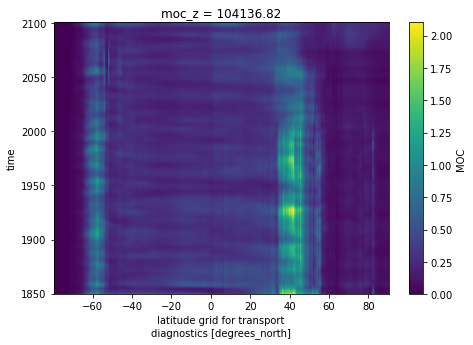

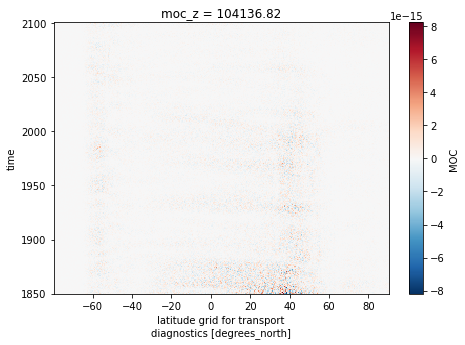

In [13]:
# Test for closure of variance budget:
sig2_resid = sig2_tot - (sig2_atm+sig2_ocn)
sig2_tot.isel(transport_reg=0).plot(size=5)
sig2_resid.isel(transport_reg=0).plot(size=5)

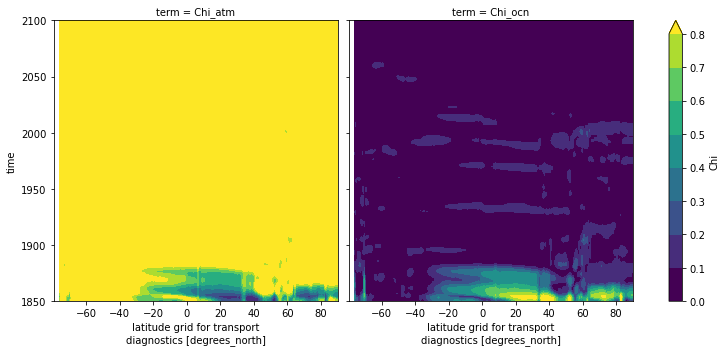

In [14]:
# Quick plot of Chi
chi = xr.concat([chi_atm,chi_ocn],dim=xr.DataArray(['Chi_atm','Chi_ocn'],dims='term',name='term'))
levs = np.arange(0,9)*0.1
chi.isel(transport_reg=0).plot.contourf(col='term',size=5,levels=levs)

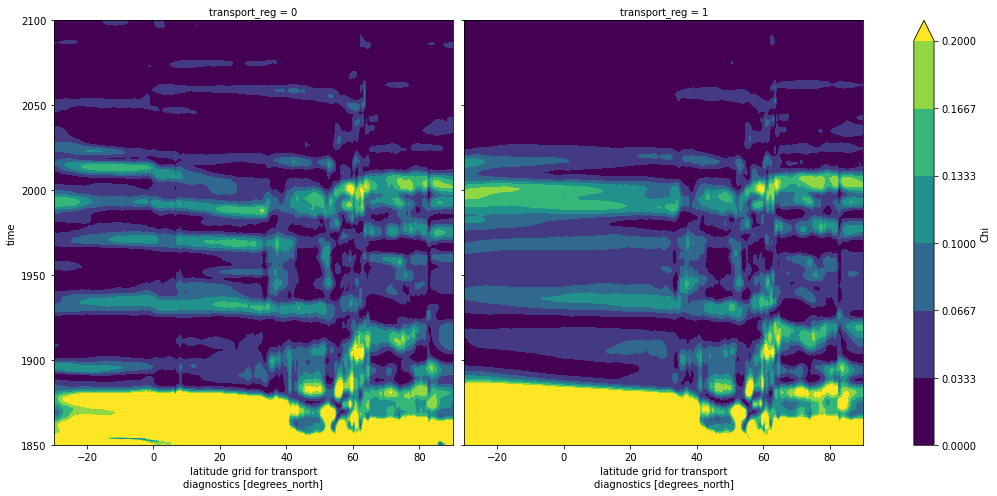

In [15]:
#fig, axes = plt.subplots(ncols=3)
chi_ocn.plot.contourf(col='transport_reg',vmin=0,vmax=0.2,size=7,xlim=[-30,90])
#chi_ocn_lpf.plot.contour(col='region',levels=[0.075],size=7,colors='r')

## Compute bootstrapped significance

In [26]:
import xskillscore as xs

Resample 80-member pool (with replacement), to generate 100 different synthetic 20-member "micro" ensembles:

In [28]:
%%time
iterations = 100
ens_size = 20
da_allmem_r = xs.resample_iterations_idx(da_allmem, iterations, 'member_id', dim_max=ens_size).rename({'iteration':'micro'}).chunk().persist()

CPU times: user 6.17 s, sys: 2.96 s, total: 9.13 s
Wall time: 9.39 s


Now, resample again to generate 500 different 4-micro combinations:

In [29]:
da_allmem_rr = xs.resample_iterations(da_allmem_r, 500, 'micro', dim_max=4)

Compute resampled distributions of sig2_atm, sig2_ocn, and chi_ocn:

In [30]:
%%time
sig2_atm_r = da_allmem_rr.var(dim='member_id').mean('micro').load()
sig2_ocn_r = da_allmem_rr.mean(dim='member_id').var('micro').load()
sig2_tot_r = da_allmem_rr.var(dim=['member_id','micro']).load()
chi_ocn_r = (sig2_ocn_r/sig2_tot_r).rename("Chi_ocn_r")

CPU times: user 10.8 s, sys: 3.1 s, total: 13.9 s
Wall time: 34.8 s


In [31]:
chi_ocn.data[:,1,0:92] = np.nan

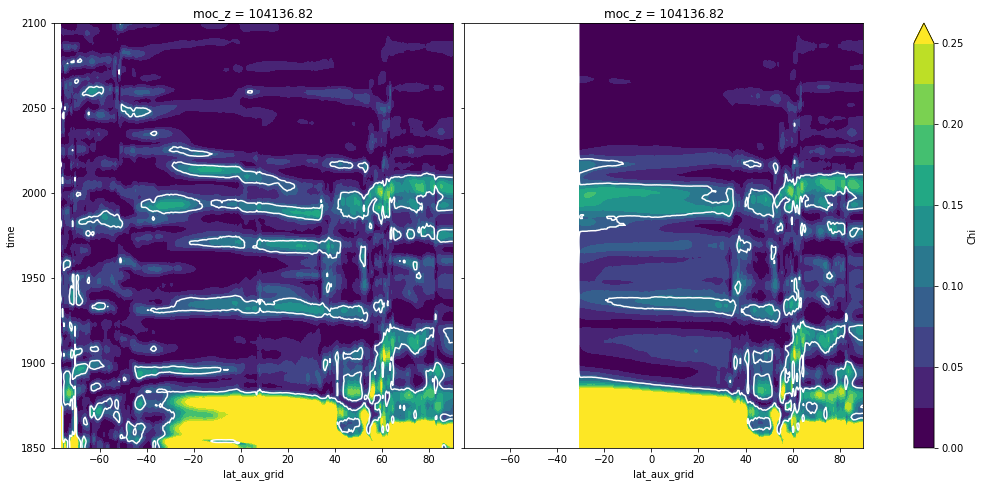

In [32]:
# Plot with bootstrapped significance
pval = (chi_ocn_r > chi_ocn).sum('iteration')/chi_ocn_r['iteration'].size
clevs = np.arange(0,11)*0.025

g = chi_ocn.plot.contourf(col='transport_reg',size=7,levels=clevs,cmap='viridis')
for i, ax in enumerate(g.axes.flat):
    pval.isel(transport_reg=i).plot.contour(ax=ax,levels=[0.05],colors=['white'])
    if (i>0): ax.set_ylabel('')

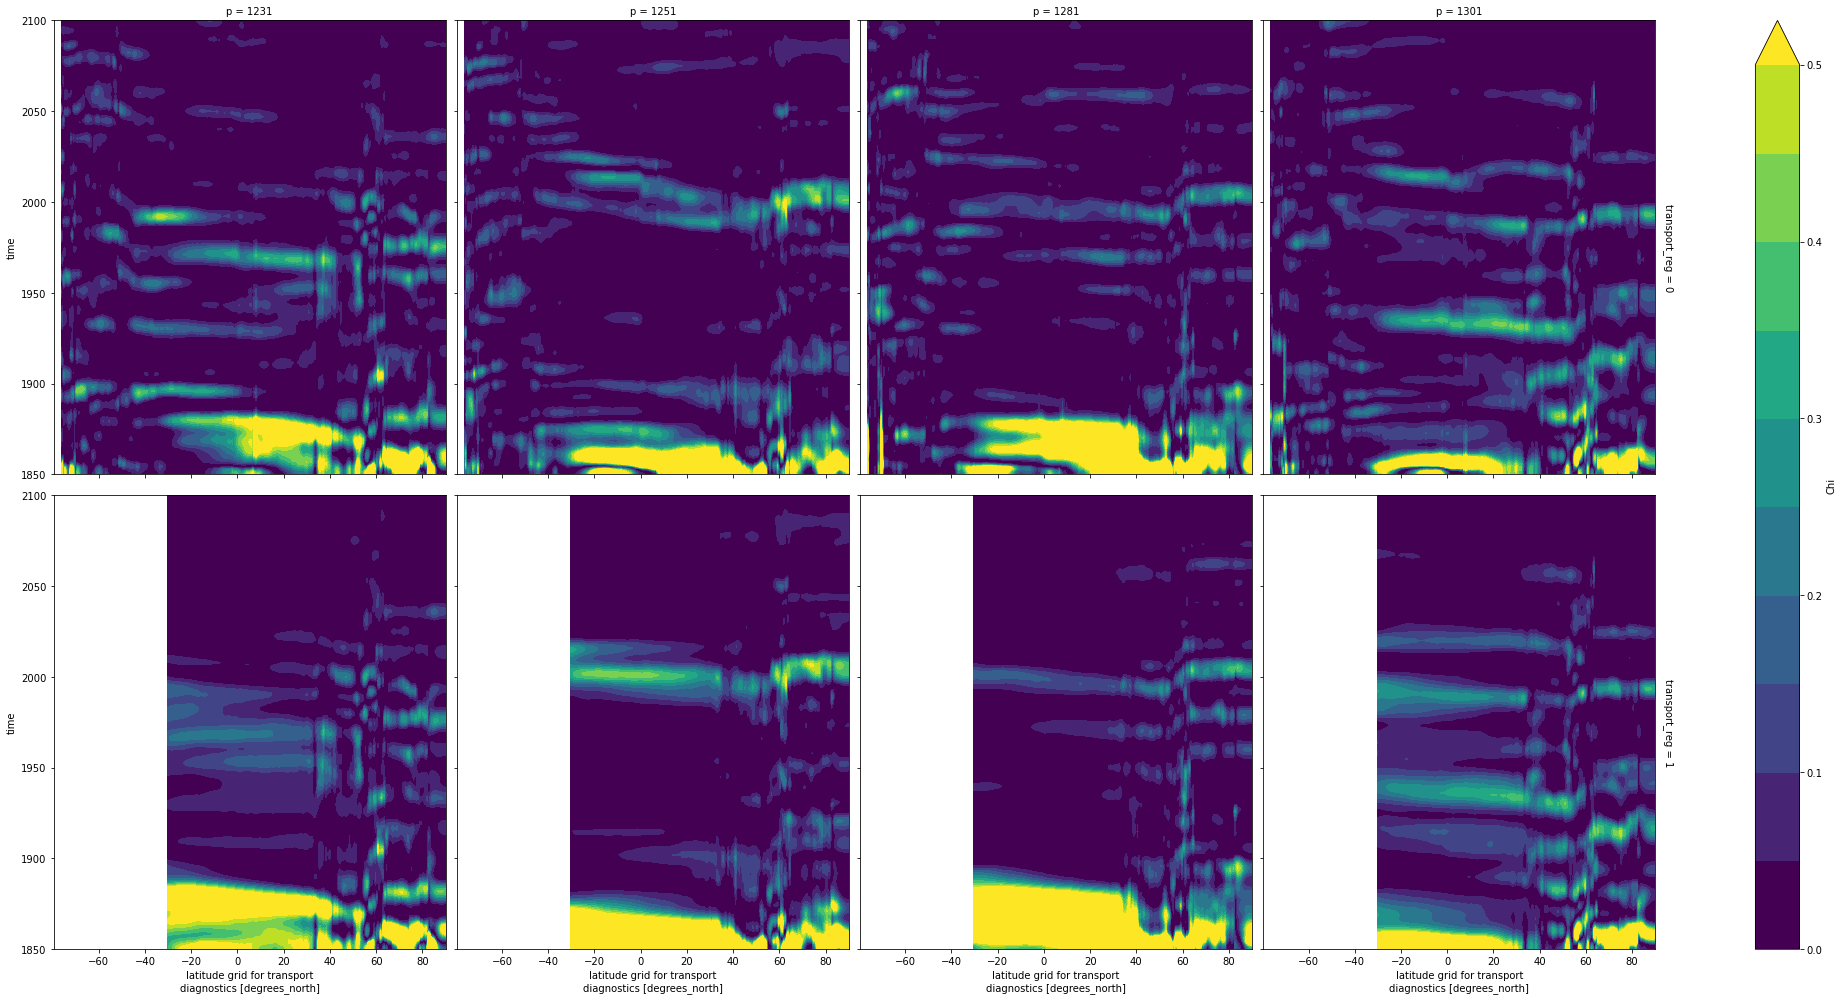

In [33]:
chi_ocn_p.data[:,:,1,0:92] = np.nan
# Plot decomposition of Chi_ocn by init year:
levs = np.arange(0,11)*0.05
chi_ocn_p.plot.contourf(col='p',row='transport_reg',size=7,levels=levs)

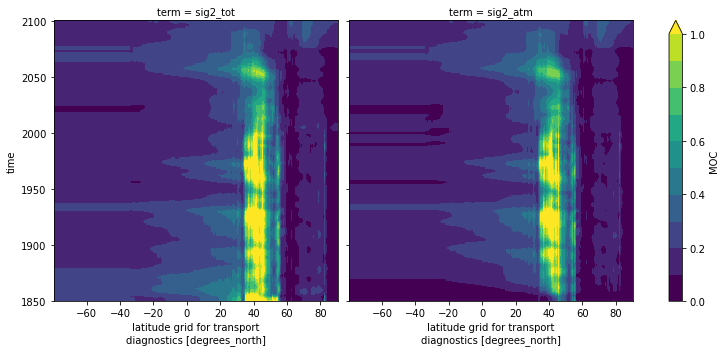

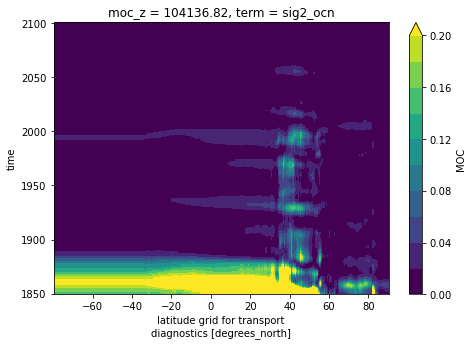

In [38]:
terms = xr.DataArray(['sig2_tot','sig2_atm','sig2_ocn','sig2_residual'],dims='term',name='term')
sig2_resid = sig2_tot - (sig2_atm+sig2_ocn)
sig2 = xr.concat([sig2_tot,sig2_atm,sig2_ocn,sig2_resid],dim=terms)

levs = np.arange(0,11)*0.1
sig2.isel(term=[0,1],transport_reg=1).plot(col='term',col_wrap=2,size=5,levels=levs)
levs = np.arange(0,11)*0.02
sig2.isel(term=2,transport_reg=1).plot(size=5,levels=levs)

## Explore Effect of Model Drift

In [16]:
def time_set_midmonth(ds, time_name):
    year = ds[time_name].dt.year
    month = ds[time_name].dt.month
    year = xr.where(month==1,year-1,year)
    month = xr.where(month==1,12,month-1)
    nmonths = len(month)
    newtime = [cftime.DatetimeNoLeap(year[i], month[i], 15) for i in range(nmonths)]
    ds[time_name] = newtime
    return ds

In [17]:
from dask.distributed import wait

In [18]:
%%time
pidir = '/glade/work/yeager/cesm_output/CESM2_picntrl/'
f0 = pidir+'b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.000101-200012.MOC.nc'
ds0 = time_set_midmonth(xr.open_dataset(f0,chunks={'time':120}),'time').persist()
daskresult = wait(ds0)

CPU times: user 6.64 s, sys: 333 ms, total: 6.97 s
Wall time: 15.6 s


In [19]:
moc30_pi = ds0.MOC.isel(transport_reg=1).sel(moc_z=100000.,lat_aux_grid=30.,method='nearest').sum('moc_comp')
moc30_pi_ann = moc30_pi.groupby('time.year').mean().rename({'year':'time'})

In [20]:
def fit_poly(dat, dim, degree):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    #dat = dat-fit
    return fit

In [21]:
trend1231 = fit_poly(moc30_pi_ann.sel(time=slice(1231,1480)),'time',1)
trend1251 = fit_poly(moc30_pi_ann.sel(time=slice(1251,1500)),'time',1)
trend1281 = fit_poly(moc30_pi_ann.sel(time=slice(1281,1530)),'time',1)
trend1301 = fit_poly(moc30_pi_ann.sel(time=slice(1301,1550)),'time',1)
trend = fit_poly(moc30_pi_ann.sel(time=slice(251,2000)),'time',1)

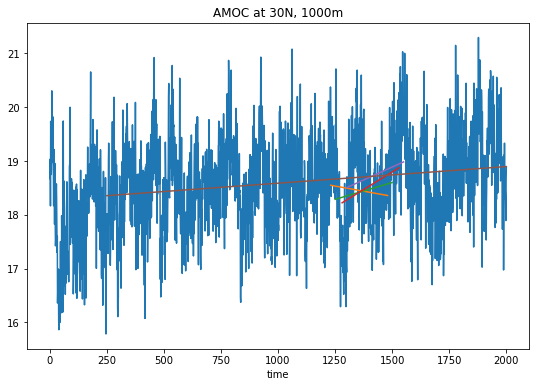

In [22]:
moc30_pi_ann.plot(size=6)
trend1231.plot()
trend1251.plot()
trend1281.plot()
trend1301.plot()
trend.plot()
plt.title("AMOC at 30N, 1000m");
#plt.draw()

In [23]:
trend.sel(time=slice(1231,1480)).time

<xarray.DataArray 'time' (time: 250)>
array([1231, 1232, 1233, ..., 1478, 1479, 1480])
Coordinates:
  * time     (time) int64 1231 1232 1233 1234 1235 ... 1476 1477 1478 1479 1480

In [25]:
moc_pi = ds0.MOC.sel(moc_z=100000.,method='nearest').sum('moc_comp')
moc_pi_ann = moc_pi.groupby('time.year').mean().rename({'year':'time'})
pitrend = fit_poly(moc_pi_ann.sel(time=slice(251,2000)),'time',1)

In [26]:
pitrend

<xarray.DataArray (time: 1750, transport_reg: 2, lat_aux_grid: 395)>
dask.array<sum-aggregate, shape=(1750, 2, 395), dtype=float64, chunksize=(1750, 2, 395), chunktype=numpy.ndarray>
Coordinates:
  * time           (time) int64 251 252 253 254 255 ... 1996 1997 1998 1999 2000
  * transport_reg  (transport_reg) int64 0 1
  * lat_aux_grid   (lat_aux_grid) float64 -79.49 -78.95 -78.42 ... 89.47 90.0

In [86]:
plist = ['1231','1251','1281','1301']
int(plist[0])

1231

In [91]:
y0 = int(plist[0])
y1 = y0+250
test = pitrend.sel(time=slice(y0,y1))
test['time'] = test['time'] + (1850-y0)

In [92]:
test.time

<xarray.DataArray 'time' (time: 251)>
array([1850, 1851, 1852, ..., 2098, 2099, 2100])
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100

In [29]:
# Compute Ensemble Variance Decomposition:
plist = ['1231','1251','1281','1301']
varlist = []
meanlist = []
iyear = ds.inityear.data
for p in plist:
    y0 = int(p)
    y1 = y0+249
    trend = pitrend.sel(time=slice(y0,y1))
    trend['time'] = trend['time'] + (1850-y0)
    memind = np.nonzero(iyear==p)
    da_oneinit = ds.MOC.isel(member_id=memind[0])
    da_oneinit = da_oneinit - trend
    var = da_oneinit.var('member_id')
    mean = da_oneinit.mean('member_id')
    varlist.append(var)
    meanlist.append(mean)
sig2_atm = xr.concat(varlist,dim='p').mean('p')
sig2_ocn = xr.concat(meanlist,dim='p').var('p')
sig2_ocn_p = xr.concat(meanlist,dim=xr.DataArray(plist,dims='p',name='p'))
sig2_ocn_p = (sig2_ocn_p - sig2_ocn_p.mean('p'))**2

# Compute Chi
chi_atm_dt = (sig2_atm/sig2_tot).rename("Chi")
chi_ocn_dt = (sig2_ocn/sig2_tot).rename("Chi")
chi_ocn_dt_p = (sig2_ocn_p/sig2_tot).rename("Chi")

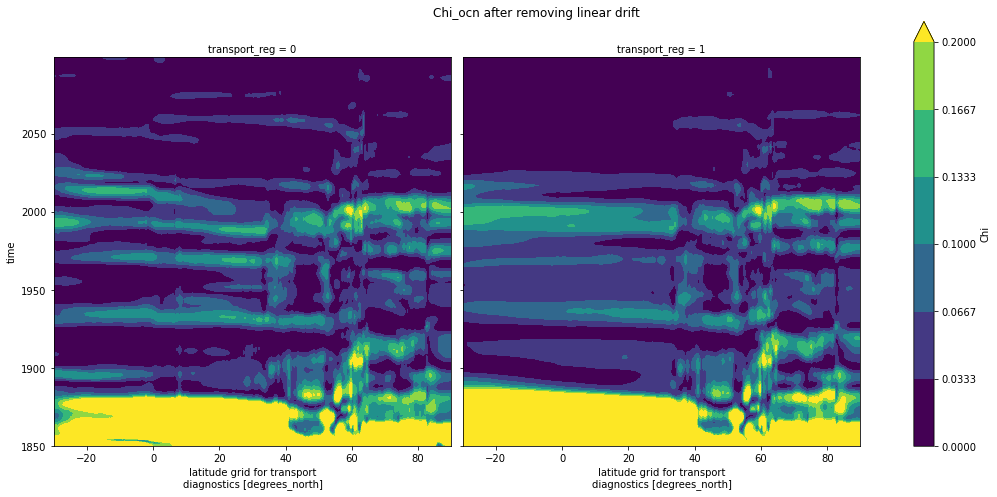

In [36]:
chi_ocn_dt.plot.contourf(col='transport_reg',vmin=0,vmax=0.2,size=7,xlim=[-30,90])
plt.suptitle("Chi_ocn after removing linear drift")
plt.subplots_adjust(top=0.88,right=0.8);

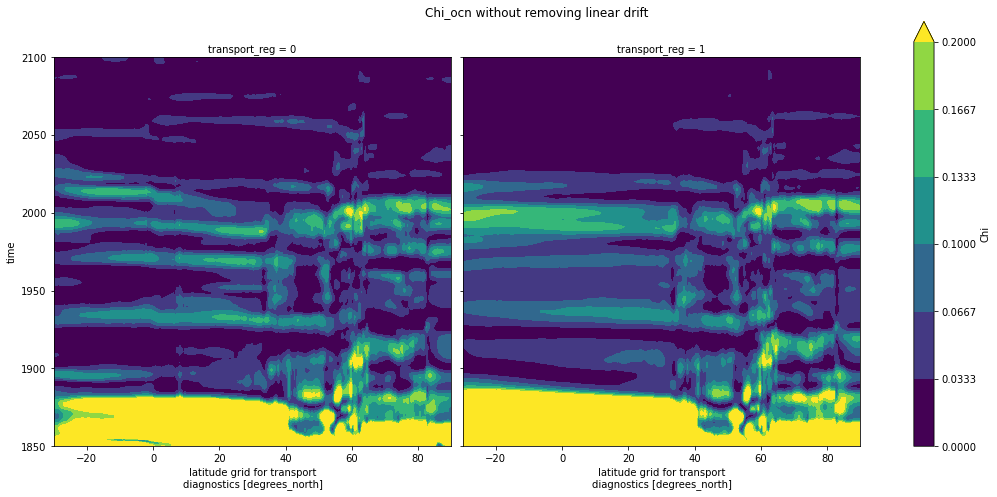

In [37]:
chi_ocn.plot.contourf(col='transport_reg',vmin=0,vmax=0.2,size=7,xlim=[-30,90])
plt.suptitle("Chi_ocn without removing linear drift")
plt.subplots_adjust(top=0.88,right=0.8);